In [ ]:
'''
Rec Engine
Notebook #3

This notebook does the bulk of the data preprocessing before setting up the recommendation engine.
A model is built using SentenceTransformer and 'all-MiniLM-L6-v2'.
The various topics are mapped in three levels: domain - topic - subtopic, then flattened and added to a pandas dataframe for embedding to a vector.
Project types are defined and refined with various heuristics.

The main dataframe of datasets is cleaned using various functions that identify project suitability, and the text is lightly cleaned prior to concatenation.
After concatenation of text, it is then embedded using the same model as the topic mapping, and uploaded to Qdrant.
'''

In [ ]:
import pandas as pd
import numpy as np
import ast, json
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from collections import defaultdict
from scipy.stats import zscore
from sentence_transformers import SentenceTransformer

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Define Topic Mappings

In [ ]:
topic_map = {
    'health': {
        'general health': [
            'medicine', 'hospital', 'insurance', 'nutrition', 'clinical',
            'diagnosis', 'drug', 'prescription'
            ],

        'mental health': [
            'depression', 'anxiety', 'therapy', 'ptsd', 'addiction', 'psychology',
            'psychiatry', 'music therapy', 'sleep'
            ],

        'public health': [
            'epidemiology', 'infectious disease', 'biostatistics', 'community health',
            'health economics', 'population health', 'social work'
            ],

        'medical fields': [
            'cardiology', 'endocrinology', 'gastroenterology', 'geriatrics',
            'hematology', 'hepatology', 'nephrology', 'neurology', 'oncology',
             'optometry', 'opthalmology' 'pediatrics', 'pulmonology', 'radiology',
            'rheumatology'
            ],

        'reproduction': [
            'gynecology', 'maternal fetal medicine', 'midwifery', 'obstetrics',
            'infertility', 'contraception', 'birth control']
        },

    'finance': {
        'personal finance': [
            'budgeting', 'credit score', 'debt management', 'student loan',
            'retirement saving', 'personal taxes', 'financial literacy'
            ],

        'corporate finance': [
            'capital structure', 'financial statements', 'mergers and acquisitions',
            'cost accounting', 'investment analysis'
            ],

        'public finance': [
            'government spending', 'public debt', 'tax policy', 'municipal budgets',
            'stimulus programs'
            ],

        'investment': [
            'stocks', 'cryptocurrency', 'bonds', 'ETFs', 'portfolio optimization',
            'trading algorithms', 'market risk', 'interest rates'
            ],

        'banking': [
            'financial institution', 'central banking', 'commercial banking',
            'regulations', 'lending practices', 'bank failures', 'mortages'
            ],

        'insurance and risk': [
            'health insurance', 'life insurance', 'property insurance',
            'actuarial models', 'risk assessment', 'premium pricing'
            ],

        'financial crime': [
            'money laundering', 'fraud detection', 'financial audits'
            ],

        'accounting': [
            'credit', 'accountant', 'taxes', 'budget', 'bookkeeping', 'equity'
            ],

        'real estate': [
            'mortgage', 'home loan'
            ],

        'economics': [
            'economy', 'scarcity', 'supply and demand', 'inflation', 'unemployment'
            ],

        'financial products': [
            'insurance', 'credit card', 'pension'
            ]
    },

    'infrastructure': {
        'transportation': [
            'vehicle', 'automobile', 'car', 'airplane', 'bus', 'transit', 'highway',
            'railway', 'bridge', 'tunnel'
            ],

        'utilities': [
            'sewage', 'electricity', 'water supply', 'trash collection',
            'garbage', 'recycling'
            ],

        'communication': [
            'internet', 'telephone', 'email', 'mail', 'broadcast', 'news',
            'television', 'radio'
            ],

        'energy': [
            'fossil fuel', 'coal', 'gasoline', 'oil', 'nuclear'
            ]
    },

    'environment': {
        'general environment': [
            'soil', 'ecology', 'biodiversity', 'pollution'
            ],

        'body of water': [
            'ocean', 'sea', 'lake', 'pond', 'river'
            ],

        'geology': [
            'magma', 'lava', 'igneous', 'metamorphic', 'sedimentary', 'rocks',
            'minerals'
            ],

        'weather': [
            'climate', 'meteorology', 'hurricane', 'tornado', 'volcano', 'thunder',
            'lightning'
            ]
    },

    'education': {
        'early childhood': [
            'preeschool', 'kindergarten readiness', 'childhood development'
            ],

        'K-12': [
            'standardized testing', 'curriculum', 'STEM education', 'reading levels',
            'school funding', 'teacher performance'
            ],

        'higher education': [
            'college enrollment', 'financial aid', 'student retention',
            'graduate', 'college ranking'
            ],

        'adult learning': [
            'continuing education', 'vocational training', 'lifelong learning'
            ],

        'educational equity': [
            'special education', 'disability services', '504 plan', 'IEP'
            ]
    },

    'government': {
        'public policy': [
            'social policy', 'economic policy', 'health policy', 'environmental policy',
            'education policy', 'housing policy', 'transportation policy'
            ],

        'government operations': [
            'budgets', 'procurement', 'public services', 'e-governace', 'bureaucracy'
            ],

        'elections': [
            'democracy', 'republic', 'voter turnout', 'campaign finance',
            'gerrymandering', 'voter registration', 'election fraud',
            'ballot initiatives', 'electoral systems'
            ],

        'legislation': [
            'bills', 'statutes', 'rulemaking', 'lobbying', 'compliance'
            ],

        'public safety': [
            'justice', 'law enforcement', 'criminal justice', 'incarceration',
            'prison', 'fire department', 'disaster response', 'emergency services'
            ]
    }
}

In [ ]:
#topic mapping for querying
topic_list = []
for domain, topics in topic_map.items():
  for topic, subtopics in topics.items():
    for subtopic in subtopics:
      topic_list.append({
          'domain': domain,
          'topic': topic,
          'subtopic': subtopic
      })

#create dataframe of topic choices
topic_choices = pd.DataFrame(topic_list)
topic_choices['concat'] = topic_choices['domain'] + ' > ' + topic_choices['topic'] + ' > ' + topic_choices['subtopic']

#get vector embedding of the concatenated topic
vectors = model.encode([
    row.concat
    for row in topic_choices.itertuples()
], show_progress_bar=True)

#add vector embeddings to the dataframe
topic_choices['embedding'] = vectors.tolist()

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
len(vectors) == len(topic_choices)

True

In [ ]:
topic_choices.head()

,domain,topic,subtopic,concat,embedding
0,health,general health,medicine,health > general health > medicine,"[0.07344535738229752, 0.012084655463695526, 0...."
1,health,general health,hospital,health > general health > hospital,"[0.050014130771160126, 0.015706082805991173, 0..."
2,health,general health,insurance,health > general health > insurance,"[0.039635006338357925, 0.03143726661801338, 0...."
3,health,general health,nutrition,health > general health > nutrition,"[0.0629931315779686, 0.010847995057702065, 0.0..."
4,health,general health,clinical,health > general health > clinical,"[0.05308666452765465, 0.03353562951087952, 0.0..."


# Define Project Types

**FYI:** The data types were first collected as a set when I was processing the main dataframe, but I curated the project types based on the available feature types. I just moved this portion above the preprocessing for organization.

In [ ]:
#define potential projects for data types
feature_to_projects = {
    'text': ['NLP', 'Sentiment Analysis', 'EDA', 'Trend Analysis'],
    'document': ['NLP', "EDA"],
    'calendar date': ['Prediction', 'Trend Analysis', 'Dashboard', 'EDA'],
    'date': ['Prediction', 'Trend Analysis', 'Dashboard', 'EDA'],
    'number': ['Prediction', 'Trend Analysis', 'Dashboard', 'EDA'],
    'checkbox': ['Prediction', 'EDA'],
    'location': ['Dashboard', 'Trend Analysis', 'EDA'],
    'point': ['Dashboard', 'EDA'],
    'line': ['Dashboard', 'EDA'],
    'polygon': ['Dashboard', 'EDA'],
    'multipoint': ['Dashboard', 'EDA'],
    'multiline': ['Dashboard', 'EDA'],
    'multipolygon': ['Dashboard', 'EDA'],
    'URL': ['Data Pipeline', 'Recommender System', 'Dashboard'],
    'photo': ['Dashboard', 'Data Pipeline']
}

In [ ]:
#flatten projects to list
all_projects = sorted({project for projects in feature_to_projects.values() for project in projects})
print(all_projects)

['Dashboard', 'Data Pipeline', 'EDA', 'NLP', 'Prediction', 'Recommender System', 'Sentiment Analysis', 'Trend Analysis']


# Data Preprocessing

In [ ]:
#read in csv file as pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/merged_df.csv')

In [ ]:
df.drop(['landing_page.1', 'name.1'], inplace=True, axis=1)
df.rename(columns={'columns': 'features'}, inplace=True)

In [ ]:
df.head()

,id,access,date_modified,date_published,description,formats,group,landing_page,medatdata_modified,name,...,organization,resources,tags,title,use_type,supported_socrata,domain,dataset_id,row_count,features
0,5e00e4fb-b65f-47ca-b8b7-92935eb9556a,public,2024-09-25,2023-09-15,"American Rescue Plan Act (ARPA) grant funds, a...","CSV, JSON, RDF, XML",Local Government,https://data.oregon.gov/d/94bm-hn7s,2024-09-27T20:22:12.712794,american-rescue-plan-act-arpa-infrastructure-p...,...,State of Oregon,"Comma Separated Values File, RDF File, JSON Fi...",['american-rescue-plan-act' 'arpa' 'covid-19' ...,American Rescue Plan Act (ARPA) Infrastructure...,notspecified,1,data.oregon.gov,94bm-hn7s,NaN,"[{'name': 'Award Year', 'type': 'text', 'descr..."
1,49c3e133-0a06-46e2-959a-2d89b8741d32,public,2024-02-02,2019-11-26,A surety bond is a promise to be liable for th...,"CSV, JSON, RDF, XML",Local Government,https://data.iowa.gov/d/fy23-jf3m,2024-02-09T11:24:45.491692,insurance-companies-authorized-to-act-as-a-sur...,...,State of Iowa,"Comma Separated Values File, RDF File, JSON Fi...",['liable' 'surety'],Insurance Companies Authorized to Act as a Sur...,notspecified,1,data.iowa.gov,fy23-jf3m,NaN,"[{'name': 'Iowa Company Number', 'type': 'text..."
2,974dc266-e798-4473-8397-425f98add043,public,2025-04-19,2021-04-07,Summary data of electric scooter usage by comp...,"CSV, JSON, RDF, XML",Local Government,https://data.bloomington.in.gov/d/guch-m6cb,2025-04-19T16:24:42.350832,scooter-activity-daily-12669,...,City of Bloomington,"Comma Separated Values File, RDF File, JSON Fi...",[],Scooter Activity Daily,other-license-specified,1,data.bloomington.in.gov,guch-m6cb,NaN,"[{'name': 'provider_name', 'type': 'text', 'de..."
3,5640e27e-4e7c-4677-967a-842e00723a20,public,2025-04-19,2019-10-29,In order to help contractors and private resid...,"CSV, JSON, RDF, XML",Local Government,https://data.cityofchicago.org/d/cygx-ui4j,2025-04-19T17:19:49.674795,dig-ticket-notifications,...,City of Chicago,"Comma Separated Values File, RDF File, JSON Fi...",['dig-ticket' 'excavation' 'transportation' 'u...,Dig Ticket Notifications,notspecified,1,data.cityofchicago.org,cygx-ui4j,NaN,"[{'name': 'DIG_TICKET#', 'type': 'number', 'de..."
4,9d46f43d-114b-4b30-9127-88c787fde54a,public,2024-06-12,2024-05-15,This dataset rates all projects in the capital...,"CSV, JSON, RDF, XML",Local Government,https://data.cityofnewyork.us/d/c99a-c5ux,2024-06-15T07:37:36.737593,nyc-climate-budgeting-report-climate-alignment...,...,City of New York,"Comma Separated Values File, RDF File, JSON Fi...",['capital-climate-investments' 'climate-alignm...,NYC Climate Budgeting Report: Climate Alignmen...,notspecified,1,data.cityofnewyork.us,c99a-c5ux,NaN,"[{'name': 'Published Date', 'type': 'calendar_..."


# Column Extraction

In [ ]:
#create dataframe of dataset feature information
data_features = df.loc[:, ['id', 'dataset_id', 'row_count', 'features']]

In [ ]:
data_features.head()

,id,dataset_id,row_count,features
0,5e00e4fb-b65f-47ca-b8b7-92935eb9556a,94bm-hn7s,NaN,"[{'name': 'Award Year', 'type': 'text', 'descr..."
1,49c3e133-0a06-46e2-959a-2d89b8741d32,fy23-jf3m,NaN,"[{'name': 'Iowa Company Number', 'type': 'text..."
2,974dc266-e798-4473-8397-425f98add043,guch-m6cb,NaN,"[{'name': 'provider_name', 'type': 'text', 'de..."
3,5640e27e-4e7c-4677-967a-842e00723a20,cygx-ui4j,NaN,"[{'name': 'DIG_TICKET#', 'type': 'number', 'de..."
4,9d46f43d-114b-4b30-9127-88c787fde54a,c99a-c5ux,NaN,"[{'name': 'Published Date', 'type': 'calendar_..."


In [ ]:
print(type(data_features['features']))

<class 'pandas.core.series.Series'>


In [ ]:
def col_convert(df, column_name):
  '''
  Convert string column to list with nested dictionary.
  Args: df (pandas dataframe), column_name (string)
  Returns: modified dataframe
  '''
  df[column_name] = df[column_name].apply(ast.literal_eval)
  return df

In [ ]:
#apply conversion function to feature column
data_features = col_convert(data_features, 'features')

In [ ]:
data_features.head()

,id,dataset_id,row_count,features
0,5e00e4fb-b65f-47ca-b8b7-92935eb9556a,94bm-hn7s,NaN,"[{'name': 'Award Year', 'type': 'text', 'descr..."
1,49c3e133-0a06-46e2-959a-2d89b8741d32,fy23-jf3m,NaN,"[{'name': 'Iowa Company Number', 'type': 'text..."
2,974dc266-e798-4473-8397-425f98add043,guch-m6cb,NaN,"[{'name': 'provider_name', 'type': 'text', 'de..."
3,5640e27e-4e7c-4677-967a-842e00723a20,cygx-ui4j,NaN,"[{'name': 'DIG_TICKET#', 'type': 'number', 'de..."
4,9d46f43d-114b-4b30-9127-88c787fde54a,c99a-c5ux,NaN,"[{'name': 'Published Date', 'type': 'calendar_..."


In [ ]:
#initialize an empty set for the feature types
feature_types = set()

In [ ]:
print(feature_types)

set()


In [ ]:
print(len(data_features))

8473


In [ ]:
#create column for feature names
data_features['feature_names'] = [[] for _ in range(len(data_features))]
data_features['feature_desc'] = [[] for _ in range(len(data_features))]

#check all feature types in data frame
for i in range(len(df)):
  #get the features info
  column_text = data_features['features'].loc[i]

  #get number of features for each dataset and return count to a new column
  data_features.loc[i, 'total_features'] = len(column_text)

  for feature in column_text:
    #each feature has 3 keys: name, type, and description
    #get the type (value) of each feature (key=type)
    value = feature.get('type')

    #add value ('type') to the feature types set
    feature_types.add(value)

    #get the feature name (value) for each feature (key=name)
    name = feature.get('name')

    #append feature name to its list
    data_features.at[i, 'feature_names'].append(name)

    #get value of description for each feature
    description = feature.get('description')

    #append feature description to a list
    data_features.at[i, 'feature_desc'].append(description)


#add each feature type as a column in the dataframe, initialize to 0
for i in feature_types:
  data_features[f'num_{i}'] = 0

for i in range(len(df)):
  features = data_features['features'].loc[i]
  for feature in features:
    #update the feature count
    data_features.loc[i, f"num_{feature['type']}"] += 1

In [ ]:
print(feature_types)

{'polygon', 'text', 'checkbox', 'number', 'date', 'multipolygon', 'document', 'point', 'line', 'photo', 'multipoint', 'multiline', 'url', 'location', 'calendar_date'}


In [ ]:
#create empty list for each type (for names to be appended)
for i in feature_types:
  data_features[f"{i}_feats"] = [[] for _ in range(len(data_features))]

In [ ]:
#create list of feature names by type
for i in range(len(df)):
  column_text = data_features['features'].loc[i]

  #iterate through each feature
  for feature in column_text:
    #get type of feature
    value = feature.get('type')

    #get feature name for each feature
    name = feature.get('name')

    #append feature name to the list of corresponding type
    data_features.at[i, f"{value}_feats"].append(name)

In [ ]:
#create set of feature types in each dataset
def extract_types(row):
  return list(set(f.get('type', '').lower() for f in row if 'type in f'))

In [ ]:
data_features['dataset_feature_types'] = data_features['features'].apply(extract_types)

## Assigning Project Types

In [ ]:
def assign_projects(feature_list, min_score=1):
  '''
  This function takes a list of features and gives a dict that indicates if a project is suitable.
  Args: feature_list (list), min_score (int)
  Returns dict {project_type: 0 or 1}
  '''
  project_counter = defaultdict(int)

  for feature in feature_list:
    #get the applicable projects from the project mapping based on data type
    projects = feature_to_projects.get(feature.lower(), [])
    for project in projects:
      project_counter[project] += 1

  return {project: int(project_counter[project] >= min_score) for project in all_projects}

In [ ]:
def project_scoring(feature_list):
  '''
  This function scores the project suitability.
  Args: feature_list(list)
  Returns dict of project counting
  '''
  project_counter = defaultdict(int)

  for feature in feature_list:
    projects = feature_to_projects.get(feature.lower(), [])
    for project in projects:
      project_counter[project] += 1

  return dict(project_counter)

In [ ]:
#score project suitability for each dataset
data_features['project_scores'] = data_features['dataset_feature_types'].apply(project_scoring)

In [ ]:
#loop over project types and apply function to assign the projects
for project in all_projects:
  data_features[project] = data_features['dataset_feature_types'].apply(
      lambda x: assign_projects(x).get(project, 0)
  )

In [ ]:
#create miniframe to view scores to determine thresholds
miniframe = data_features.loc[:, ['id', 'project_scores']]

#extract individual scores to their own column
for project in all_projects:
  miniframe[f'{project}_score'] = miniframe['project_scores'].apply(lambda x: x.get(project, 0))

In [ ]:
print(all_projects)

['Dashboard', 'Data Pipeline', 'EDA', 'NLP', 'Prediction', 'Recommender System', 'Sentiment Analysis', 'Trend Analysis']


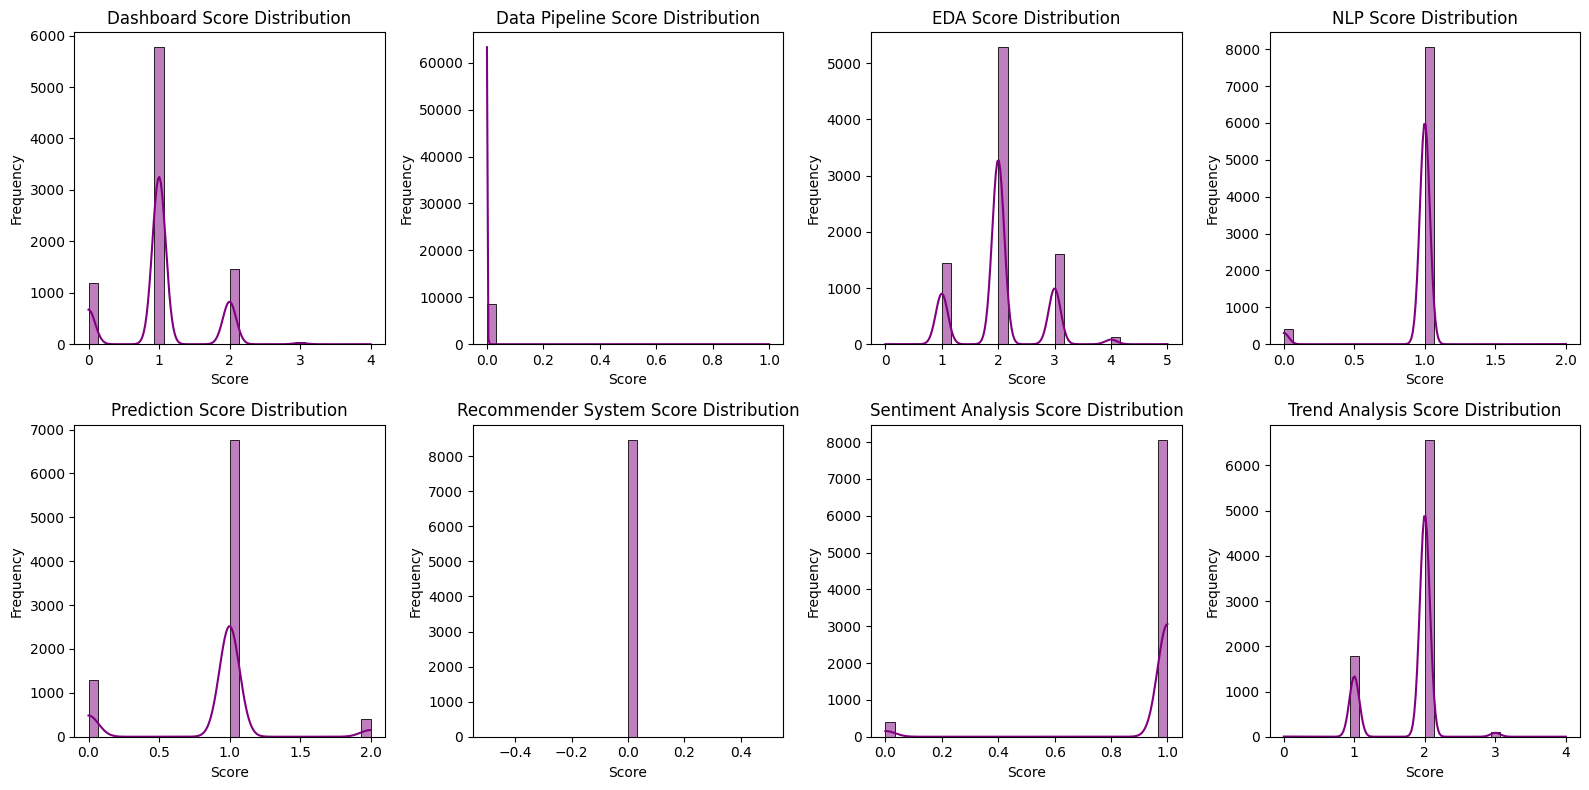

In [ ]:
#plot distribution for each project type
plt.figure(figsize=(16, 8))

for i, project in enumerate(all_projects, 1):
  plt.subplot(2, 4, i)
  sns.histplot(miniframe[f'{project}_score'], bins=30, kde=True, color='purple')
  plt.title(f'{project} Score Distribution')
  plt.xlabel('Score')
  plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Pretty much all of the heuristics for each project type need refining.

In [ ]:
miniframe.head()

,id,project_scores,Dashboard_score,Data Pipeline_score,EDA_score,NLP_score,Prediction_score,Recommender System_score,Sentiment Analysis_score,Trend Analysis_score
0,5e00e4fb-b65f-47ca-b8b7-92935eb9556a,"{'NLP': 1, 'Sentiment Analysis': 1, 'EDA': 2, ...",1,0,2,1,1,0,1,2
1,49c3e133-0a06-46e2-959a-2d89b8741d32,"{'Prediction': 1, 'Trend Analysis': 2, 'Dashbo...",2,0,3,1,1,0,1,2
2,974dc266-e798-4473-8397-425f98add043,"{'NLP': 1, 'Sentiment Analysis': 1, 'EDA': 2, ...",1,0,2,1,1,0,1,2
3,5640e27e-4e7c-4677-967a-842e00723a20,"{'NLP': 1, 'Sentiment Analysis': 1, 'EDA': 4, ...",2,0,4,1,2,0,1,2
4,9d46f43d-114b-4b30-9127-88c787fde54a,"{'NLP': 1, 'Sentiment Analysis': 1, 'EDA': 2, ...",1,0,2,1,1,0,1,2


### Recommender Engine

In [ ]:
def rec_score(row):
  score = 0
  score += row['num_checkbox'] * 1
  score += row['num_text'] * 1
  score += row['num_document'] * 1
  score += row['num_url'] * 1
  score += row['num_number'] * 1
  return score

In [ ]:
#apply updated rec score heuristic
data_features['recscore'] = data_features.apply(rec_score, axis=1)

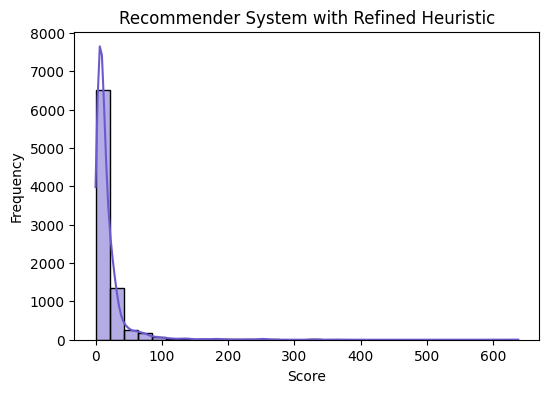

In [ ]:
#plot distribution using updated recscore
plt.figure(figsize=(6, 4))
sns.histplot(data_features['recscore'], bins=30, kde=True, color='slateblue')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Recommender System with Refined Heuristic')
plt.show()

In [ ]:
#normalize recommender score to zscore
for project in all_projects:
  data_features['rec_norm'] = zscore(data_features['recscore'])

#flag top cands
data_features['rec_flag'] = (data_features['rec_norm'] > 1).astype(int)

#filter top candidates
rec_cands = data_features[data_features['rec_flag'] == 1]

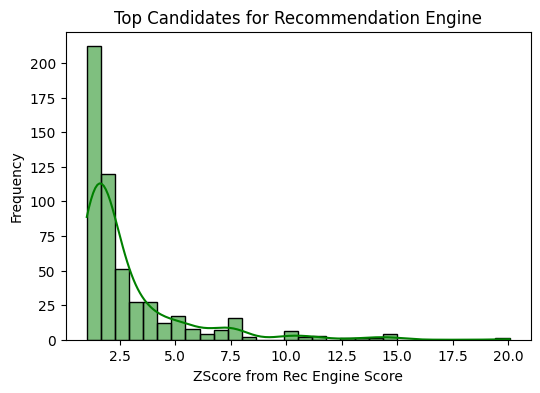

In [ ]:
#view top candidates
plt.figure(figsize=(6, 4))
sns.histplot(rec_cands['rec_norm'], bins=30, kde=True, color='green')
plt.xlabel('ZScore from Rec Engine Score')
plt.ylabel('Frequency')
plt.title('Top Candidates for Recommendation Engine')
plt.show()

### Prediction

In [ ]:
def prediction_score(row):
  score = 0
  score += row.get('num_number', 0) * 1
  score += row.get('num_text', 0) * 0.5
  score += row.get('num_checkbox', 0) * 1
  score += row.get('num_date', 0) * 0.5
  return score

In [ ]:
#apply updated prediction score heuristic
data_features['predscore'] = data_features.apply(prediction_score, axis=1)

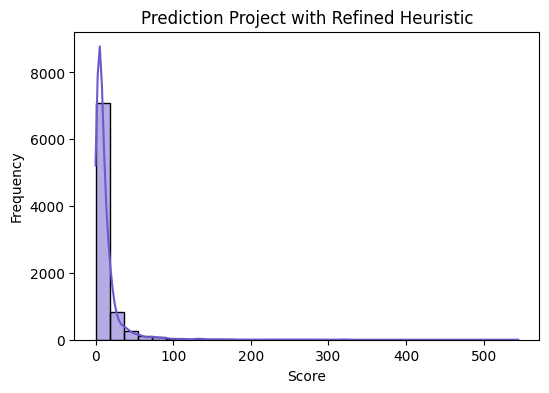

In [ ]:
#plot distribution using updated predscore
plt.figure(figsize=(6, 4))
sns.histplot(data_features['predscore'], bins=30, kde=True, color='slateblue')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Prediction Project with Refined Heuristic')
plt.show()

In [ ]:
#normalize prediction score to zscore
for project in all_projects:
  data_features['pred_norm'] = zscore(data_features['predscore'])

#flag top cands
data_features['pred_flag'] = (data_features['pred_norm'] > 1).astype(int)

#filter top candidates
pred_cands = data_features[data_features['pred_flag'] == 1]

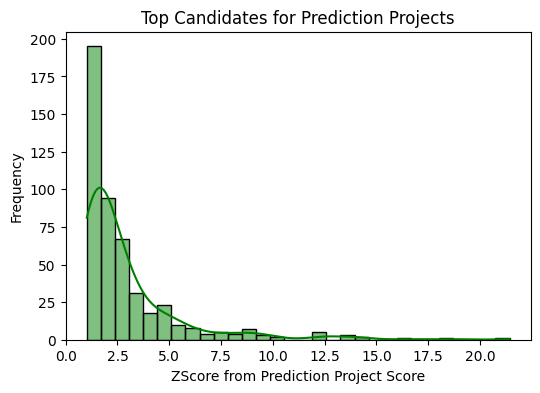

In [ ]:
#view top candidates
plt.figure(figsize=(6, 4))
sns.histplot(pred_cands['pred_norm'], bins=30, kde=True, color='green')
plt.xlabel('ZScore from Prediction Project Score')
plt.ylabel('Frequency')
plt.title('Top Candidates for Prediction Projects')
plt.show()

### NLP

In [ ]:
def nlp_score(row):
  score = 0
  score += row.get('num_text', 0) * 1.5
  score += row.get('num_document', 0) * 2
  score += row.get('num_checkbox', 0) * 0.5
  score += row.get('num_url', 0) * 0.25
  return score

In [ ]:
#apply updated score heuristic
data_features['nlpscore'] = data_features.apply(nlp_score, axis=1)

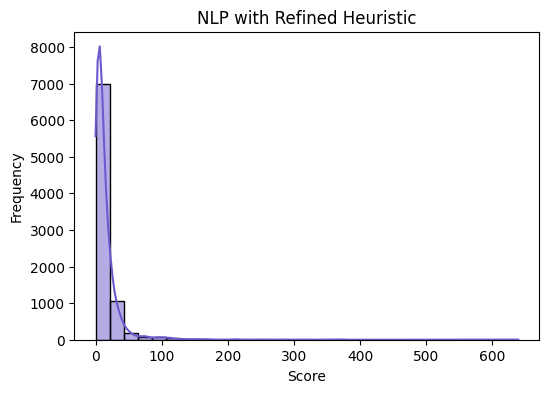

In [ ]:
#plot distribution using updated score
plt.figure(figsize=(6, 4))
sns.histplot(data_features['nlpscore'], bins=30, kde=True, color='slateblue')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('NLP with Refined Heuristic')
plt.show()

In [ ]:
#normalize score to zscore
for project in all_projects:
  data_features['nlp_norm'] = zscore(data_features['nlpscore'])

#flag top cands
data_features['nlp_flag'] = (data_features['nlp_norm'] > 1).astype(int)

#filter top candidates
nlp_cands = data_features[data_features['nlp_flag'] == 1]

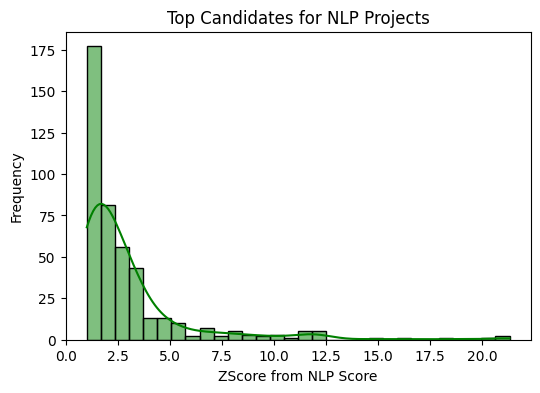

In [ ]:
#view top candidates
plt.figure(figsize=(6, 4))
sns.histplot(nlp_cands['nlp_norm'], bins=30, kde=True, color='green')
plt.xlabel('ZScore from NLP Score')
plt.ylabel('Frequency')
plt.title('Top Candidates for NLP Projects')
plt.show()

### Trend Analysis

In [ ]:
def trend_score(row):
  score = 0
  #weight date more as its key to this type of project
  score += row.get('num_date', 0) * 2
  score += row.get('num_number', 0) * 1
  score += row.get('num_calendar date', 0) * 2
  score += row.get('num_text', 0) * 0.5
  return score

In [ ]:
#apply updated score heuristic
data_features['trendscore'] = data_features.apply(trend_score, axis=1)

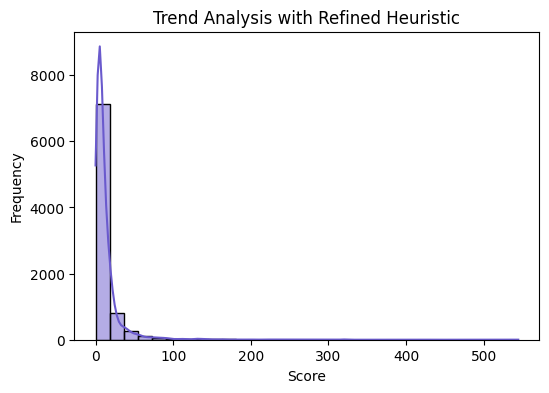

In [ ]:
#plot distribution using updated score
plt.figure(figsize=(6, 4))
sns.histplot(data_features['trendscore'], bins=30, kde=True, color='slateblue')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Trend Analysis with Refined Heuristic')
plt.show()

In [ ]:
#normalize score to zscore
for project in all_projects:
  data_features['trend_norm'] = zscore(data_features['trendscore'])

#flag top cands
data_features['trend_flag'] = (data_features['trend_norm'] > 1).astype(int)

#filter top candidates
trend_cands = data_features[data_features['trend_flag'] == 1]

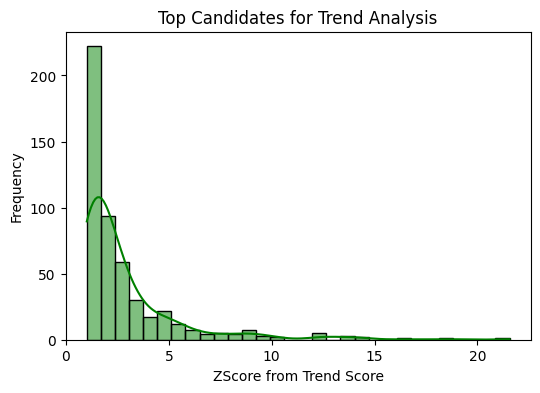

In [ ]:
#view top candidates
plt.figure(figsize=(6, 4))
sns.histplot(trend_cands['trend_norm'], bins=30, kde=True, color='green')
plt.xlabel('ZScore from Trend Score')
plt.ylabel('Frequency')
plt.title('Top Candidates for Trend Analysis')
plt.show()

### Sentiment Analysis

In [ ]:
#create set of potential keywords to look for to associate with sentiment analysis
sentiment_keywords = {'feedback', 'sentiment', 'emotion', 'opinion', 'keyword', 'comments'}

def sentiment_score(row):
  score = 0
  score += row.get('num_text', 0) * 2
  score += row.get('num_document', 0) * 1.5
  score += row.get('num_checkbox', 0) * 0.5
  score += row.get('num_number', 0) * 0.25
  score += row.get('num_url', 0) * 0.25

  #see if any sentiment-related keywords appear in feature names or descriptions
  feat_names = ' '.join(row.get('feat_names', [])).lower()
  feat_desc = ' '.join(row.get('feat_description', [])).lower()

  #boost score if true
  if any(i in feat_names for i in sentiment_keywords):
    score += 1.5
  if any(i in feat_desc for i in sentiment_keywords):
    score += 1.5

  return score

In [ ]:
#apply updated score heuristic
data_features['sentimentscore'] = data_features.apply(sentiment_score, axis=1)

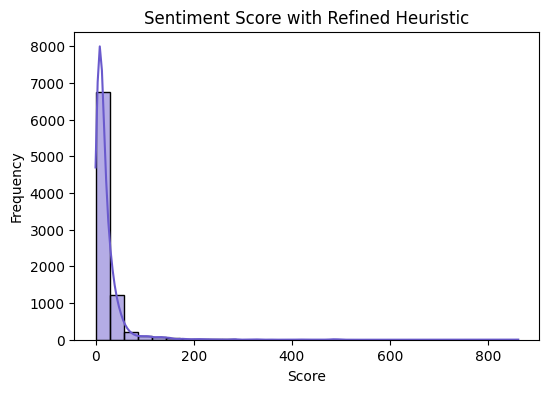

In [ ]:
#plot distribution using updated score
plt.figure(figsize=(6, 4))
sns.histplot(data_features['sentimentscore'], bins=30, kde=True, color='slateblue')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score with Refined Heuristic')
plt.show()

In [ ]:
#normalize score to zscore
for project in all_projects:
  data_features['sentiment_norm'] = zscore(data_features['sentimentscore'])

#flag top cands
data_features['sentiment_flag'] = (data_features['sentiment_norm'] > 1).astype(int)

#filter top candidates
sent_cands = data_features[data_features['sentiment_flag'] == 1]

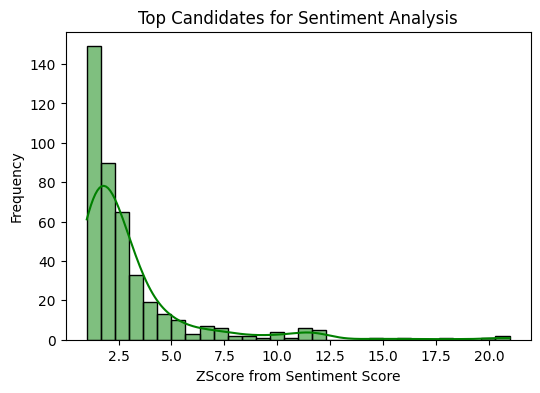

In [ ]:
#view top candidates
plt.figure(figsize=(6, 4))
sns.histplot(sent_cands['sentiment_norm'], bins=30, kde=True, color='green')
plt.xlabel('ZScore from Sentiment Score')
plt.ylabel('Frequency')
plt.title('Top Candidates for Sentiment Analysis')
plt.show()

### Data Pipeline

In [ ]:
def pipeline_score(row):
  score = 0
  #this one is best for a variety and complexity of data to do multiple ETL/transformations
  score += len(set([i for i in [
      'num_text', 'num_number', 'num_checkbox', 'num_document', 'num_date',
      'num_url', 'num_url', 'num_location', 'num_photo', 'num_polygon', 'num_point',
      'num_calendar date', 'num_multiline', 'num_multipolygon', 'num_multipoint'
      ] if row.get(i, 0) > 0
                    #apply bonus if heterogeneous data
                    ])) * 1.5
  score += sum([
      row.get('num_text', 0),
      row.get('num_number', 0),
      row.get('num_date', 0),
      row.get('num_checkbox', 0)
  ]) * 0.5

  return score

In [ ]:
data_features['pipelinescore'] = data_features.apply(pipeline_score, axis=1)

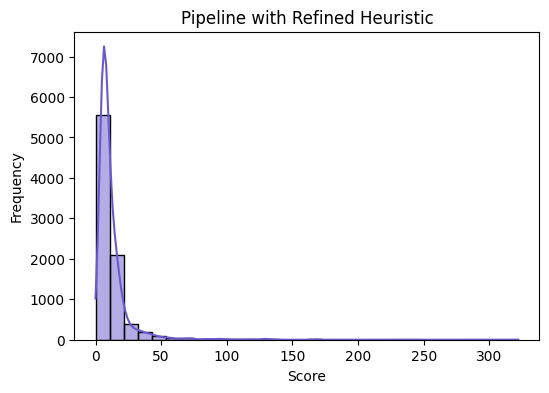

In [ ]:
#plot distribution using updated score
plt.figure(figsize=(6, 4))
sns.histplot(data_features['pipelinescore'], bins=30, kde=True, color='slateblue')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Pipeline with Refined Heuristic')
plt.show()

In [ ]:
#normalize score to zscore
for project in all_projects:
  data_features['pipeline_norm'] = zscore(data_features['pipelinescore'])

#flag top cands
data_features['pipeline_flag'] = (data_features['pipeline_norm'] > 1).astype(int)

#filter top candidates
pipeline_cands = data_features[data_features['pipeline_flag'] == 1]

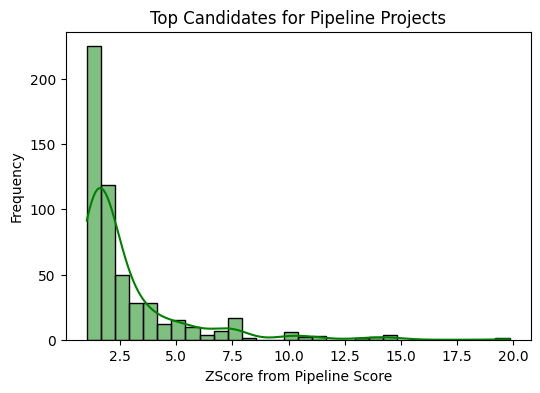

In [ ]:
#view top candidates
plt.figure(figsize=(6, 4))
sns.histplot(pipeline_cands['pipeline_norm'], bins=30, kde=True, color='green')
plt.xlabel('ZScore from Pipeline Score')
plt.ylabel('Frequency')
plt.title('Top Candidates for Pipeline Projects')
plt.show()

### EDA & Dashboard

In [ ]:
#merge EDA and Dashboard scores with data_features
data_features = pd.merge(data_features, miniframe[['id', 'EDA_score', 'Dashboard_score']], on='id', how='left')

Pretty much any data can be used for EDA or a Dashboard, so I didn't refine these heuristics or normalize the scoring.

## Additional

In [ ]:
data_features.head()

,id,dataset_id,row_count,features,feature_names,feature_desc,total_features,num_polygon,num_text,num_checkbox,...,trend_norm,trend_flag,sentimentscore,sentiment_norm,sentiment_flag,pipelinescore,pipeline_norm,pipeline_flag,EDA_score,Dashboard_score
0,5e00e4fb-b65f-47ca-b8b7-92935eb9556a,94bm-hn7s,NaN,"[{'name': 'Award Year', 'type': 'text', 'descr...","[Award Year, Organization Receiving Award, Use...","[Award Year, Organization Receiving Award, Use...",5.0,0,4,0,...,-0.407976,0,8.25,-0.347093,0,5.5,-0.433052,0,2,1
1,49c3e133-0a06-46e2-959a-2d89b8741d32,fy23-jf3m,NaN,"[{'name': 'Iowa Company Number', 'type': 'text...","[Iowa Company Number, NAIC Number, Phone, Comp...","[, , , , , , , , , , , ]",12.0,0,8,0,...,-0.245708,0,16.75,-0.134753,0,10.0,-0.144753,0,3,2
2,974dc266-e798-4473-8397-425f98add043,guch-m6cb,NaN,"[{'name': 'provider_name', 'type': 'text', 'de...","[provider_name, day, trips, available_scooters...","[, , , , , ]",6.0,0,1,0,...,-0.347125,0,3.00,-0.478243,0,5.5,-0.433052,0,2,1
3,5640e27e-4e7c-4677-967a-842e00723a20,cygx-ui4j,NaN,"[{'name': 'DIG_TICKET#', 'type': 'number', 'de...","[DIG_TICKET#, PERMIT#, REQUESTDATE, EMERGENCY,...",[Dig ticket number which can be reviewed throu...,30.0,0,10,2,...,0.159963,0,24.00,0.046360,0,18.0,0.367779,0,4,2
4,9d46f43d-114b-4b30-9127-88c787fde54a,c99a-c5ux,NaN,"[{'name': 'Published Date', 'type': 'calendar_...","[Published Date, Project Id, Project Descripti...","[Date data published, CAPITAL PROJECT IDENTIFI...",18.0,0,16,0,...,-0.164574,0,32.25,0.252454,0,11.5,-0.048653,0,2,1


In [ ]:
#summary statistics for number of features per dataset
data_features['total_features'].describe().round(1)

,total_features
count,8473.0
mean,19.3
std,31.1
min,1.0
25%,6.0
50%,11.0
75%,22.0
max,638.0


In [ ]:
#pull pieces of project info for frame use
project_frame = data_features.loc[:, ['id', 'dataset_id', 'rec_norm', 'pred_norm',
                                      'nlp_norm', 'trend_norm', 'sentiment_norm',
                                      'pipeline_norm', 'EDA_score', 'Dashboard_score']]

In [ ]:
project_frame.head()

,id,dataset_id,rec_norm,pred_norm,nlp_norm,trend_norm,sentiment_norm,pipeline_norm,EDA_score,Dashboard_score
0,5e00e4fb-b65f-47ca-b8b7-92935eb9556a,94bm-hn7s,-0.430474,-0.412910,-0.312087,-0.407976,-0.347093,-0.433052,2,1
1,49c3e133-0a06-46e2-959a-2d89b8741d32,fy23-jf3m,-0.236350,-0.251591,-0.107082,-0.245708,-0.134753,-0.144753,3,2
2,974dc266-e798-4473-8397-425f98add043,guch-m6cb,-0.430474,-0.352415,-0.465840,-0.347125,-0.478243,-0.433052,2,1
3,5640e27e-4e7c-4677-967a-842e00723a20,cygx-ui4j,0.184254,0.232366,0.029587,0.159963,0.046360,0.367779,4,2
4,9d46f43d-114b-4b30-9127-88c787fde54a,c99a-c5ux,-0.042225,-0.170931,0.302927,-0.164574,0.252454,-0.048653,2,1


# NLP & TF-IDF Calculation

## Preprocess text

In [ ]:
#feature names and feature descriptions
feature_frame = data_features.loc[:, ['id', 'feature_names', 'feature_desc']]

In [ ]:
feature_frame.head()

,id,feature_names,feature_desc
0,5e00e4fb-b65f-47ca-b8b7-92935eb9556a,"[Award Year, Organization Receiving Award, Use...","[Award Year, Organization Receiving Award, Use..."
1,49c3e133-0a06-46e2-959a-2d89b8741d32,"[Iowa Company Number, NAIC Number, Phone, Comp...","[, , , , , , , , , , , ]"
2,974dc266-e798-4473-8397-425f98add043,"[provider_name, day, trips, available_scooters...","[, , , , , ]"
3,5640e27e-4e7c-4677-967a-842e00723a20,"[DIG_TICKET#, PERMIT#, REQUESTDATE, EMERGENCY,...",[Dig ticket number which can be reviewed throu...
4,9d46f43d-114b-4b30-9127-88c787fde54a,"[Published Date, Project Id, Project Descripti...","[Date data published, CAPITAL PROJECT IDENTIFI..."


In [ ]:
#create topic df for NLP and vectorizing
topic_df = df.loc[:, ['id', 'title', 'description', 'tags']]

In [ ]:
topic_df.head()

,id,title,description,tags
0,5e00e4fb-b65f-47ca-b8b7-92935eb9556a,American Rescue Plan Act (ARPA) Infrastructure...,"American Rescue Plan Act (ARPA) grant funds, a...",['american-rescue-plan-act' 'arpa' 'covid-19' ...
1,49c3e133-0a06-46e2-959a-2d89b8741d32,Insurance Companies Authorized to Act as a Sur...,A surety bond is a promise to be liable for th...,['liable' 'surety']
2,974dc266-e798-4473-8397-425f98add043,Scooter Activity Daily,Summary data of electric scooter usage by comp...,[]
3,5640e27e-4e7c-4677-967a-842e00723a20,Dig Ticket Notifications,In order to help contractors and private resid...,['dig-ticket' 'excavation' 'transportation' 'u...
4,9d46f43d-114b-4b30-9127-88c787fde54a,NYC Climate Budgeting Report: Climate Alignmen...,This dataset rates all projects in the capital...,['capital-climate-investments' 'climate-alignm...


In [ ]:
topic_df = pd.merge(topic_df, feature_frame, on='id')

In [ ]:
topic_df.head()

,id,title,description,tags,feature_names,feature_desc
0,5e00e4fb-b65f-47ca-b8b7-92935eb9556a,American Rescue Plan Act (ARPA) Infrastructure...,"American Rescue Plan Act (ARPA) grant funds, a...",['american-rescue-plan-act' 'arpa' 'covid-19' ...,"[Award Year, Organization Receiving Award, Use...","[Award Year, Organization Receiving Award, Use..."
1,49c3e133-0a06-46e2-959a-2d89b8741d32,Insurance Companies Authorized to Act as a Sur...,A surety bond is a promise to be liable for th...,['liable' 'surety'],"[Iowa Company Number, NAIC Number, Phone, Comp...","[, , , , , , , , , , , ]"
2,974dc266-e798-4473-8397-425f98add043,Scooter Activity Daily,Summary data of electric scooter usage by comp...,[],"[provider_name, day, trips, available_scooters...","[, , , , , ]"
3,5640e27e-4e7c-4677-967a-842e00723a20,Dig Ticket Notifications,In order to help contractors and private resid...,['dig-ticket' 'excavation' 'transportation' 'u...,"[DIG_TICKET#, PERMIT#, REQUESTDATE, EMERGENCY,...",[Dig ticket number which can be reviewed throu...
4,9d46f43d-114b-4b30-9127-88c787fde54a,NYC Climate Budgeting Report: Climate Alignmen...,This dataset rates all projects in the capital...,['capital-climate-investments' 'climate-alignm...,"[Published Date, Project Id, Project Descripti...","[Date data published, CAPITAL PROJECT IDENTIFI..."


In [ ]:
print(type(topic_df['tags']))

<class 'pandas.core.series.Series'>


In [ ]:
def convert_to_string(df, col):
  df[col] = df[col].astype(str)
  df[col] = df[col].str.replace("'", "")
  df[col] = df[col].str.replace("[", "")
  df[col] = df[col].str.replace("]", "")
  df[col] = df[col].str.replace("[]", "")
  return df

In [ ]:
cols_to_clean = ['tags', 'feature_names', 'feature_desc']

for i in cols_to_clean:
  convert_to_string(topic_df, i)

In [ ]:
#concatenate five "text" columns - title, description, tags, feature names, and feature descriptions
topic_df['text_concat'] = topic_df['title'] + ' ' + topic_df['description'] + ' ' + topic_df['tags'] + topic_df['feature_names'] + topic_df['feature_desc']

In [ ]:
import re
from bs4 import BeautifulSoup

def clean_text(text):
  '''
  Takes text and cleans it by removing any HTML formatting and URL links.
  '''
  if isinstance(text, str):
    text = BeautifulSoup(text, 'html.parser').get_text(separator=' ')
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    return text.strip()
  return ''

In [ ]:
#apply cleaning function to the concatenated text column
topic_df['text_clean'] = topic_df['text_concat'].apply(clean_text)

In [ ]:
topic_df.head()

,id,title,description,tags,feature_names,feature_desc,text_concat,text_clean
0,5e00e4fb-b65f-47ca-b8b7-92935eb9556a,American Rescue Plan Act (ARPA) Infrastructure...,"American Rescue Plan Act (ARPA) grant funds, a...",american-rescue-plan-act arpa covid-19 fiscal-...,"Award Year, Organization Receiving Award, Use ...","Award Year, Organization Receiving Award, Use ...",American Rescue Plan Act (ARPA) Infrastructure...,American Rescue Plan Act (ARPA) Infrastructure...
1,49c3e133-0a06-46e2-959a-2d89b8741d32,Insurance Companies Authorized to Act as a Sur...,A surety bond is a promise to be liable for th...,liable surety,"Iowa Company Number, NAIC Number, Phone, Compa...",", , , , , , , , , , ,",Insurance Companies Authorized to Act as a Sur...,Insurance Companies Authorized to Act as a Sur...
2,974dc266-e798-4473-8397-425f98add043,Scooter Activity Daily,Summary data of electric scooter usage by comp...,,"provider_name, day, trips, available_scooters,...",", , , , ,",Scooter Activity Daily Summary data of electri...,Scooter Activity Daily Summary data of electri...
3,5640e27e-4e7c-4677-967a-842e00723a20,Dig Ticket Notifications,In order to help contractors and private resid...,dig-ticket excavation transportation utilities,"DIG_TICKET#, PERMIT#, REQUESTDATE, EMERGENCY, ...",Dig ticket number which can be reviewed throug...,Dig Ticket Notifications In order to help cont...,Dig Ticket Notifications In order to help cont...
4,9d46f43d-114b-4b30-9127-88c787fde54a,NYC Climate Budgeting Report: Climate Alignmen...,This dataset rates all projects in the capital...,capital-climate-investments climate-alignment-...,"Published Date, Project Id, Project Descriptio...","Date data published, CAPITAL PROJECT IDENTIFIC...",NYC Climate Budgeting Report: Climate Alignmen...,NYC Climate Budgeting Report: Climate Alignmen...


In [ ]:
text_vectors = model.encode([
    row.text_clean
    for row in topic_df.itertuples()
], show_progress_bar=True)

Batches:   0%|          | 0/265 [00:00<?, ?it/s]

In [ ]:
#add vector embeddings to the dataframe
topic_df['embedding'] = text_vectors.tolist()

In [ ]:
topic_df.head()

,id,title,description,tags,feature_names,feature_desc,text_concat,text_clean,embedding
0,5e00e4fb-b65f-47ca-b8b7-92935eb9556a,American Rescue Plan Act (ARPA) Infrastructure...,"American Rescue Plan Act (ARPA) grant funds, a...",american-rescue-plan-act arpa covid-19 fiscal-...,"Award Year, Organization Receiving Award, Use ...","Award Year, Organization Receiving Award, Use ...",American Rescue Plan Act (ARPA) Infrastructure...,American Rescue Plan Act (ARPA) Infrastructure...,"[-0.01702122949063778, -0.009256698191165924, ..."
1,49c3e133-0a06-46e2-959a-2d89b8741d32,Insurance Companies Authorized to Act as a Sur...,A surety bond is a promise to be liable for th...,liable surety,"Iowa Company Number, NAIC Number, Phone, Compa...",", , , , , , , , , , ,",Insurance Companies Authorized to Act as a Sur...,Insurance Companies Authorized to Act as a Sur...,"[-0.044725507497787476, 0.048931002616882324, ..."
2,974dc266-e798-4473-8397-425f98add043,Scooter Activity Daily,Summary data of electric scooter usage by comp...,,"provider_name, day, trips, available_scooters,...",", , , , ,",Scooter Activity Daily Summary data of electri...,Scooter Activity Daily Summary data of electri...,"[0.07611490041017532, 0.007965127937495708, -0..."
3,5640e27e-4e7c-4677-967a-842e00723a20,Dig Ticket Notifications,In order to help contractors and private resid...,dig-ticket excavation transportation utilities,"DIG_TICKET#, PERMIT#, REQUESTDATE, EMERGENCY, ...",Dig ticket number which can be reviewed throug...,Dig Ticket Notifications In order to help cont...,Dig Ticket Notifications In order to help cont...,"[-0.046820975840091705, -0.059252697974443436,..."
4,9d46f43d-114b-4b30-9127-88c787fde54a,NYC Climate Budgeting Report: Climate Alignmen...,This dataset rates all projects in the capital...,capital-climate-investments climate-alignment-...,"Published Date, Project Id, Project Descriptio...","Date data published, CAPITAL PROJECT IDENTIFIC...",NYC Climate Budgeting Report: Climate Alignmen...,NYC Climate Budgeting Report: Climate Alignmen...,"[0.06785226613283157, -0.008908952586352825, 0..."


In [ ]:
#get shape of the vectors
text_vectors.shape

(8473, 384)

In [ ]:
#download saved vectors and continue
np.save('datasetvectors.npy', vectors, allow_pickle=False)

# Merge Dataframes

In [ ]:
#merge project dataframe and topic dataframe
merged_df = pd.merge(project_frame, topic_df, on='id', how='left')

In [ ]:
merged_df.head()

,id,dataset_id,rec_norm,pred_norm,nlp_norm,trend_norm,sentiment_norm,pipeline_norm,EDA_score,Dashboard_score,title,description,tags,feature_names,feature_desc,text_concat,text_clean,embedding
0,5e00e4fb-b65f-47ca-b8b7-92935eb9556a,94bm-hn7s,-0.430474,-0.412910,-0.312087,-0.407976,-0.347093,-0.433052,2,1,American Rescue Plan Act (ARPA) Infrastructure...,"American Rescue Plan Act (ARPA) grant funds, a...",american-rescue-plan-act arpa covid-19 fiscal-...,"Award Year, Organization Receiving Award, Use ...","Award Year, Organization Receiving Award, Use ...",American Rescue Plan Act (ARPA) Infrastructure...,American Rescue Plan Act (ARPA) Infrastructure...,"[-0.01702122949063778, -0.009256698191165924, ..."
1,49c3e133-0a06-46e2-959a-2d89b8741d32,fy23-jf3m,-0.236350,-0.251591,-0.107082,-0.245708,-0.134753,-0.144753,3,2,Insurance Companies Authorized to Act as a Sur...,A surety bond is a promise to be liable for th...,liable surety,"Iowa Company Number, NAIC Number, Phone, Compa...",", , , , , , , , , , ,",Insurance Companies Authorized to Act as a Sur...,Insurance Companies Authorized to Act as a Sur...,"[-0.044725507497787476, 0.048931002616882324, ..."
2,974dc266-e798-4473-8397-425f98add043,guch-m6cb,-0.430474,-0.352415,-0.465840,-0.347125,-0.478243,-0.433052,2,1,Scooter Activity Daily,Summary data of electric scooter usage by comp...,,"provider_name, day, trips, available_scooters,...",", , , , ,",Scooter Activity Daily Summary data of electri...,Scooter Activity Daily Summary data of electri...,"[0.07611490041017532, 0.007965127937495708, -0..."
3,5640e27e-4e7c-4677-967a-842e00723a20,cygx-ui4j,0.184254,0.232366,0.029587,0.159963,0.046360,0.367779,4,2,Dig Ticket Notifications,In order to help contractors and private resid...,dig-ticket excavation transportation utilities,"DIG_TICKET#, PERMIT#, REQUESTDATE, EMERGENCY, ...",Dig ticket number which can be reviewed throug...,Dig Ticket Notifications In order to help cont...,Dig Ticket Notifications In order to help cont...,"[-0.046820975840091705, -0.059252697974443436,..."
4,9d46f43d-114b-4b30-9127-88c787fde54a,c99a-c5ux,-0.042225,-0.170931,0.302927,-0.164574,0.252454,-0.048653,2,1,NYC Climate Budgeting Report: Climate Alignmen...,This dataset rates all projects in the capital...,capital-climate-investments climate-alignment-...,"Published Date, Project Id, Project Descriptio...","Date data published, CAPITAL PROJECT IDENTIFIC...",NYC Climate Budgeting Report: Climate Alignmen...,NYC Climate Budgeting Report: Climate Alignmen...,"[0.06785226613283157, -0.008908952586352825, 0..."


In [ ]:
#merge dataframe with dataset info from original dataframe
clean_dataframe = pd.merge(merged_df, df[['id', 'org', 'landing_page']], on='id', how='left')

In [ ]:
clean_dataframe.head()

,id,dataset_id,rec_norm,pred_norm,nlp_norm,trend_norm,sentiment_norm,pipeline_norm,EDA_score,Dashboard_score,title,description,tags,feature_names,feature_desc,text_concat,text_clean,embedding,org,landing_page
0,5e00e4fb-b65f-47ca-b8b7-92935eb9556a,94bm-hn7s,-0.430474,-0.412910,-0.312087,-0.407976,-0.347093,-0.433052,2,1,American Rescue Plan Act (ARPA) Infrastructure...,"American Rescue Plan Act (ARPA) grant funds, a...",american-rescue-plan-act arpa covid-19 fiscal-...,"Award Year, Organization Receiving Award, Use ...","Award Year, Organization Receiving Award, Use ...",American Rescue Plan Act (ARPA) Infrastructure...,American Rescue Plan Act (ARPA) Infrastructure...,"[-0.01702122949063778, -0.009256698191165924, ...",state-of-oregon,https://data.oregon.gov/d/94bm-hn7s
1,49c3e133-0a06-46e2-959a-2d89b8741d32,fy23-jf3m,-0.236350,-0.251591,-0.107082,-0.245708,-0.134753,-0.144753,3,2,Insurance Companies Authorized to Act as a Sur...,A surety bond is a promise to be liable for th...,liable surety,"Iowa Company Number, NAIC Number, Phone, Compa...",", , , , , , , , , , ,",Insurance Companies Authorized to Act as a Sur...,Insurance Companies Authorized to Act as a Sur...,"[-0.044725507497787476, 0.048931002616882324, ...",state-of-iowa,https://data.iowa.gov/d/fy23-jf3m
2,974dc266-e798-4473-8397-425f98add043,guch-m6cb,-0.430474,-0.352415,-0.465840,-0.347125,-0.478243,-0.433052,2,1,Scooter Activity Daily,Summary data of electric scooter usage by comp...,,"provider_name, day, trips, available_scooters,...",", , , , ,",Scooter Activity Daily Summary data of electri...,Scooter Activity Daily Summary data of electri...,"[0.07611490041017532, 0.007965127937495708, -0...",city-of-bloomington,https://data.bloomington.in.gov/d/guch-m6cb
3,5640e27e-4e7c-4677-967a-842e00723a20,cygx-ui4j,0.184254,0.232366,0.029587,0.159963,0.046360,0.367779,4,2,Dig Ticket Notifications,In order to help contractors and private resid...,dig-ticket excavation transportation utilities,"DIG_TICKET#, PERMIT#, REQUESTDATE, EMERGENCY, ...",Dig ticket number which can be reviewed throug...,Dig Ticket Notifications In order to help cont...,Dig Ticket Notifications In order to help cont...,"[-0.046820975840091705, -0.059252697974443436,...",city-of-chicago,https://data.cityofchicago.org/d/cygx-ui4j
4,9d46f43d-114b-4b30-9127-88c787fde54a,c99a-c5ux,-0.042225,-0.170931,0.302927,-0.164574,0.252454,-0.048653,2,1,NYC Climate Budgeting Report: Climate Alignmen...,This dataset rates all projects in the capital...,capital-climate-investments climate-alignment-...,"Published Date, Project Id, Project Descriptio...","Date data published, CAPITAL PROJECT IDENTIFIC...",NYC Climate Budgeting Report: Climate Alignmen...,NYC Climate Budgeting Report: Climate Alignmen...,"[0.06785226613283157, -0.008908952586352825, 0...",city-of-new-york,https://data.cityofnewyork.us/d/c99a-c5ux


In [ ]:
clean_dataframe.shape

(8473, 20)

#Qdrant

In [ ]:
!pip install qdrant_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.7/327.7 kB 17.3 MB/s eta 0:00:00


In [ ]:
import math
from qdrant_client import QdrantClient
from qdrant_client.http import models

In [ ]:
def upload_datasets_to_qdrant(
    df,
    collection_name,
    qdrant_url,
    qdrant_api_key,
    vector_column='embedding',
    id_column='id',
    batch_size=500,
    #distance='Cosine'
):
  '''
  Uploads the dataframe to Qdrant.
  '''
  #determine vector size from first row
  #vector_dim = len(df[vector_column].iloc[0])

  #create client
  client = QdrantClient(
      url=qdrant_url,
      api_key=qdrant_api_key
  )

  #create collection if it doesn't exist
  if not client.collection_exists(collection_name):
    print(f'Collection {collection_name} not found. Creating it...')
    client.recreate_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(
            size=384,
            distance=models.Distance.COSINE
        )
    )
  else:
    print(f'Collection {collection_name} exists.')

  #upload data in batches
  print(f'Uploading {len(df)} records to collection: {collection_name}')

  #calculate batches
  num_batches = math.ceil(len(df) / batch_size)

  #create progress bar
  for i in tqdm(range(num_batches), desc='Uploading to Qdrant', unit='batch'):
    batch_df = df.iloc[i * batch_size: (i+1) * batch_size]

    #initialize lists for batch
    ids = []
    vectors = []
    payloads = []

    for row in batch_df.itertuples():
      ids.append(str(getattr(row, id_column)))
      vectors.append(getattr(row, vector_column))
      payloads.append({
                "dataset_id": row.dataset_id,
                "title": row.title,
                "description": row.description,
                "tags": row.tags,
                "feature_names": row.feature_names,
                "feature_desc": row.feature_desc,
                "org": row.org,
                "landing_page": row.landing_page,
                "score_rec": row.rec_norm,
                "score_pred": row.pred_norm,
                "score_nlp": row.nlp_norm,
                "score_trend": row.trend_norm,
                "score_sentiment": row.sentiment_norm,
                "score_pipeline": row.pipeline_norm,
                "score_eda": row.EDA_score,
                "score_dashboard": row.Dashboard_score,
            })

      client.upsert(
          collection_name=collection_name,
          points=models.Batch.construct(
              ids=ids,
              vectors=vectors,
              payloads=payloads
          )
      )
  print(f'All uploaded.')

In [ ]:
#upload to qdrant
upload_datasets_to_qdrant(
    df=clean_dataframe,
    collection_name='dataset_recommender',
    qdrant_url='REDACTED',
    qdrant_api_key='REDACTED'
)

Collection dataset_recommender not found. Creating it...


<ipython-input-113-f0c568a1976a>:26: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


Uploading 8473 records to collection: dataset_recommender


Uploading to Qdrant:   0%|          | 0/17 [00:00<?, ?batch/s]<ipython-input-113-f0c568a1976a>:75: PydanticDeprecatedSince20: The `construct` method is deprecated; use `model_construct` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  points=models.Batch.construct(
Uploading to Qdrant: 100%|██████████| 17/17 [15:47<00:00, 55.72s/batch]

All uploaded.


In [ ]:
import uuid
#generate a UUID for each row in topic dataframe
topic_choices['qdrant_id'] = [str(uuid.uuid4()) for _ in range(len(topic_choices))]

In [ ]:
topic_choices.head()

,domain,topic,subtopic,concat,embedding,qdrant_id
0,health,general health,medicine,health > general health > medicine,"[0.07344535738229752, 0.012084655463695526, 0....",3109366a-abe2-4a86-95de-303e6921cf87
1,health,general health,hospital,health > general health > hospital,"[0.050014130771160126, 0.015706082805991173, 0...",64d5206c-4817-4aba-9ca1-51388a2ccd59
2,health,general health,insurance,health > general health > insurance,"[0.039635006338357925, 0.03143726661801338, 0....",f727b77a-dd68-4965-ab6d-3bc229c3f54e
3,health,general health,nutrition,health > general health > nutrition,"[0.0629931315779686, 0.010847995057702065, 0.0...",d62f76d1-b2a4-44ce-b9d8-baa09bfcd269
4,health,general health,clinical,health > general health > clinical,"[0.05308666452765465, 0.03353562951087952, 0.0...",5d9839fd-30ff-4f9d-9c8a-faf704bddda4


In [ ]:
def upload_topics_to_qdrant(
    df,
    collection_name,
    qdrant_url,
    qdrant_api_key,
    vector_column='embedding',
    id_column='qdrant_id'
):

  #create client
  client = QdrantClient(
      url=qdrant_url,
      api_key=qdrant_api_key
  )

  #create collection if it doesn't exist
  if not client.collection_exists(collection_name):
    print(f'Collection {collection_name} not found. Creating it...')
    client.recreate_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(
            size=384,
            distance=models.Distance.COSINE
        )
    )
  else:
    print(f'Collection {collection_name} exists.')

  #add info
  ids = df[id_column].astype(str).tolist()
  vectors = df[vector_column].tolist()
  payloads = df[['domain', 'topic', 'subtopic', 'concat']].to_dict(orient='records')

  client.upsert(
      collection_name=collection_name,
      points=models.Batch.construct(
          ids=ids,
          vectors=vectors,
          payloads=payloads
      )
  )

In [ ]:
#upload to qdrant
upload_topics_to_qdrant(
    df=topic_choices,
    collection_name='topic_embeddings',
    qdrant_url='REDACTED',
    qdrant_api_key='REDACTED'
)

Collection topic_embeddings exists.


<ipython-input-123-2accf89f50bd>:36: PydanticDeprecatedSince20: The `construct` method is deprecated; use `model_construct` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  points=models.Batch.construct(
